In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 데이터 불러오기

In [9]:
data = pd.read_csv(os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [10]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## 데이터 전처리

In [11]:
# 결측값 확인
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

In [12]:
# 중복 데이터 확인
data[data.duplicated('Q') == True]

,Q,A,label
196,고양이 키우고 싶어,가족들과 상의해보세요.,0
235,공시 준비 힘들어,잘 될 거예요.,0
1294,돈 벌고 싶어,많이 벌수록 좋아요.,0
1445,로또 번호 알려줘,알면 제가 하죠.,0
1481,마음이 울적해,거리를 걸어보세요.,0
...,...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.,2
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.,2
11658,첫사랑 생각나,지금의 사랑에 충실하세요.,2
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.,2


In [13]:
data[data.duplicated('A') == True]

,Q,A,label
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.,0
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.,0
...,...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.,2
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.,2
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.,2
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.,2


In [14]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    sentence = re.sub(r"[^ㄱ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [15]:
questions = list(map(preprocess_sentence, data['Q'].values))
answers = list(map(preprocess_sentence, data['A'].values))
questions[:10], answers[:10]

(['12시 땡 !',
  '1지망 학교 떨어졌어',
  '3박4일 놀러가고 싶다',
  '3박4일 정도 놀러가고 싶다',
  'ppl 심하네',
  'sd카드 망가졌어',
  'sd카드 안돼',
  'sns 맞팔 왜 안하지ㅠㅠ',
  'sns 시간낭비인 거 아는데 매일 하는 중',
  'sns 시간낭비인데 자꾸 보게됨'],
 ['하루가 또 가네요 .',
  '위로해 드립니다 .',
  '여행은 언제나 좋죠 .',
  '여행은 언제나 좋죠 .',
  '눈살이 찌푸려지죠 .',
  '다시 새로 사는 게 마음 편해요 .',
  '다시 새로 사는 게 마음 편해요 .',
  '잘 모르고 있을 수도 있어요 .',
  '시간을 정하고 해보세요 .',
  '시간을 정하고 해보세요 .'])

In [16]:
# 결과 확인
print(f'Q의 전체 값 : {len(questions)}')
print(f'A의 전체 값 : {len(answers)}')

Q의 전체 값 : 11823
A의 전체 값 : 11823


In [17]:
for i in range(10, 20):
    print(f'전처리 후의 {i+1}번째 질문, 답변 : {questions[i]} / {answers[i]}')

전처리 후의 11번째 질문, 답변 : sns보면 나만 빼고 다 행복해보여 / 자랑하는 자리니까요 .
전처리 후의 12번째 질문, 답변 : 가끔 궁금해 / 그 사람도 그럴 거예요 .
전처리 후의 13번째 질문, 답변 : 가끔 뭐하는지 궁금해 / 그 사람도 그럴 거예요 .
전처리 후의 14번째 질문, 답변 : 가끔은 혼자인게 좋다 / 혼자를 즐기세요 .
전처리 후의 15번째 질문, 답변 : 가난한 자의 설움 / 돈은 다시 들어올 거예요 .
전처리 후의 16번째 질문, 답변 : 가만 있어도 땀난다 / 땀을 식혀주세요 .
전처리 후의 17번째 질문, 답변 : 가상화폐 쫄딱 망함 / 어서 잊고 새출발 하세요 .
전처리 후의 18번째 질문, 답변 : 가스불 켜고 나갔어 / 빨리 집에 돌아가서 끄고 나오세요 .
전처리 후의 19번째 질문, 답변 : 가스불 켜놓고 나온거 같아 / 빨리 집에 돌아가서 끄고 나오세요 .
전처리 후의 20번째 질문, 답변 : 가스비 너무 많이 나왔다 . / 다음 달에는 더 절약해봐요 .


## SubwordTextEncoder 사용하기

In [18]:
# 단어장
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [19]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 수 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 수 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 수 : [8170]
END_TOKEN의 수 : [8171]


In [20]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


In [21]:
# 인코딩 및 패딩
print(f'정수 인코딩 후의 20번째 질문, 답변 : {tokenizer.encode(questions[19])} / {tokenizer.encode(answers[19])}')

정수 인코딩 후의 20번째 질문, 답변 : [5761, 610, 6, 19, 3111, 55, 1] / [2356, 7510, 7, 6273, 97, 1]


In [22]:
que_len = [len(s.split()) for s in questions]
ans_len = [len(s.split()) for s in answers]

In [23]:
MAX_LENGTH = 25
print(MAX_LENGTH)

25


In [24]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [25]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11817
필터링 후의 답변 샘플 개수: 11817


## 모델 구현

In [26]:
# 포지셔널 인코딩
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [27]:
# 스케일드 닷 프로덕트 어텐션
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    if mask is not None:
        logits += (mask * -1e9)
        
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    output = tf.matmul(attention_weights, value)
    
    return output

In [28]:
# 멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        
        outputs = self.dense(concat_attention)
        
        return outputs

In [29]:
# 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    
    return tf.maximum(look_ahead_mask, padding_mask)

In [30]:
# 인코더
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
# 인코더
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
        
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f"encoder_layer_{i}",
        )([outputs, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
# 디코더
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)
    
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })
    
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [33]:
# 디코더
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f'decoder_layer_{i}',
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [34]:
# 트랜스포머
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
    
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [35]:
# 모델 생성
tf.keras.backend.clear_session()

NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [36]:
# 손실 함수
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

In [37]:
# 학습률
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [38]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [39]:
# 교사 강요
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [40]:
# 모델 훈련
EPOCHS = 25
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/25
185/185 [==============================] - 14s 41ms/step - loss: 2.3677 - accuracy: 0.0490
Epoch 2/25
185/185 [==============================] - 7s 40ms/step - loss: 1.9190 - accuracy: 0.0803
Epoch 3/25
185/185 [==============================] - 8s 41ms/step - loss: 1.6313 - accuracy: 0.0818
Epoch 4/25
185/185 [==============================] - 8s 41ms/step - loss: 1.5064 - accuracy: 0.0881
Epoch 5/25
185/185 [==============================] - 8s 41ms/step - loss: 1.4121 - accuracy: 0.0934
Epoch 6/25
185/185 [==============================] - 8s 41ms/step - loss: 1.3147 - accuracy: 0.1002
Epoch 7/25
185/185 [==============================] - 8s 41ms/step - loss: 1.2063 - accuracy: 0.1099
Epoch 8/25
185/185 [==============================] - 8s 41ms/step - loss: 1.0869 - accuracy: 0.1229
Epoch 9/25
185/185 [==============================] - 8s 41ms/step - loss: 0.9581 - accuracy: 0.1371
Epoch 10/25
185/185 [==============================] - 8s 41ms/step - loss: 0.8260 - accur

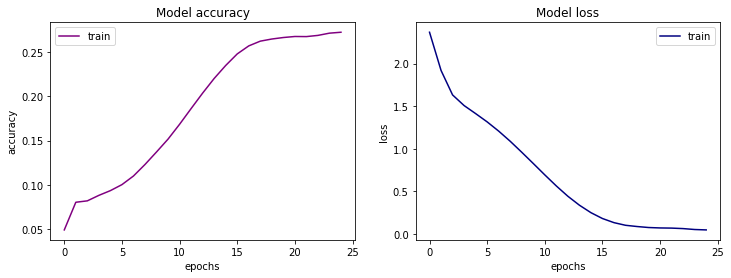

In [41]:
# 확인
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.ravel()
colors = ['purple', 'navy']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met], color=colors[i])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train'])

## 모델 평가

In [42]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    
    return tf.squeeze(output_sequence, axis=0)

In [43]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    
    return predicted_sentence

In [44]:
sentence_generation('반가워')

입력 : 반가워
출력 : 반갑습니다 .


'반갑습니다 .'

In [45]:
sentence_generation('뭐해')

입력 : 뭐해
출력 : 수다떨고 영화보고 책보기 등등 다양하게 할 수 있어요 .


'수다떨고 영화보고 책보기 등등 다양하게 할 수 있어요 .'

In [46]:
sentence_generation('밥 뭐 먹지')

입력 : 밥 뭐 먹지
출력 : 색다른걸 드셔보세요 .


'색다른걸 드셔보세요 .'

In [47]:
sentence_generation('잘 지내?')

입력 : 잘 지내?
출력 : 당신은 잘 지내고 있나봅니다 .


'당신은 잘 지내고 있나봅니다 .'

In [48]:
sentence_generation('졸리다')

입력 : 졸리다
출력 : 잠을 깨요 ! 기운 내요 ! !


'잠을 깨요 ! 기운 내요 ! !'

In [49]:
sentence_generation('퇴근하자')

입력 : 퇴근하자
출력 : 째깍 .


'째깍 .'

## 마치며
* 예상과는 달리 학습이 잘 돼서 말이 되는 게 신기함.
* 한국어로는 학습시키는 게 처음이라 잘 될지 걱정했지만, 그래도 모델링과 학습을 잘 돌렸기에 이런 결과가 도출되었다고 생각함.